In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# بارگذاری دیتاست
train_data = pd.read_csv('Training.csv')
test_data = pd.read_csv('Testing.csv')

In [3]:
# حذف ستون‌های اضافی (در صورت وجود)
if 'Unnamed: 133' in train_data.columns:
    train_data = train_data.drop(columns=['Unnamed: 133'])
if 'Unnamed: 133' in test_data.columns:
    test_data = test_data.drop(columns=['Unnamed: 133'])

In [4]:
# رمزگذاری ستون 'prognosis' به عنوان هدف
label_encoder = LabelEncoder()
train_data['prognosis_encoded'] = label_encoder.fit_transform(train_data['prognosis'])
test_data['prognosis_encoded'] = label_encoder.transform(test_data['prognosis'])

# جداسازی ویژگی‌ها و هدف
X = train_data.drop(columns=['prognosis', 'prognosis_encoded'])
y = train_data['prognosis_encoded']
X_test = test_data.drop(columns=['prognosis', 'prognosis_encoded'])
y_test = test_data['prognosis_encoded']

In [5]:
# تقسیم داده به ۸۰٪ آموزش و ۲۰٪ اعتبارسنجی
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import imblearn
print(imblearn.__version__)

0.12.4


In [8]:
from imblearn.over_sampling import SMOTE
# تولید داده‌های مصنوعی با SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

In [10]:
import numpy as np
# افزودن نویز به داده‌ها (به عنوان مثال، نویز گوسی)
noise_factor = 0.1
X_train_noisy = X_train_resampled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_resampled.shape)


In [32]:
# تعداد نمونه‌های قبل و بعد از SMOTE
print(f"Original training data size: {X_train_split.shape[0]}")
print(f"Resampled training data size: {X_train_resampled.shape[0]}")

Original training data size: 3936
Resampled training data size: 4305


In [11]:
# تعریف مدل‌ها
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

In [12]:
# تعداد ویژگی‌های مختلف برای آزمایش
feature_counts = range(5, X.shape[1] + 1, 5)

# ذخیره دقت‌ها برای رسم نمودار
model_accuracies = {model_name: [] for model_name in models.keys()}

In [13]:
# حلقه برای هر مدل و هر تعداد ویژگی
for model_name, model in models.items():
    for n_features in feature_counts:
        # انتخاب ویژگی‌ها با RFE
        rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=n_features)
        X_train_rfe = rfe.fit_transform(X_train_split, y_train_split)
        X_val_rfe = rfe.transform(X_val)

        # آموزش مدل و محاسبه دقت
        model.fit(X_train_rfe, y_train_split)
        val_accuracy = accuracy_score(y_val, model.predict(X_val_rfe))
        model_accuracies[model_name].append(val_accuracy)

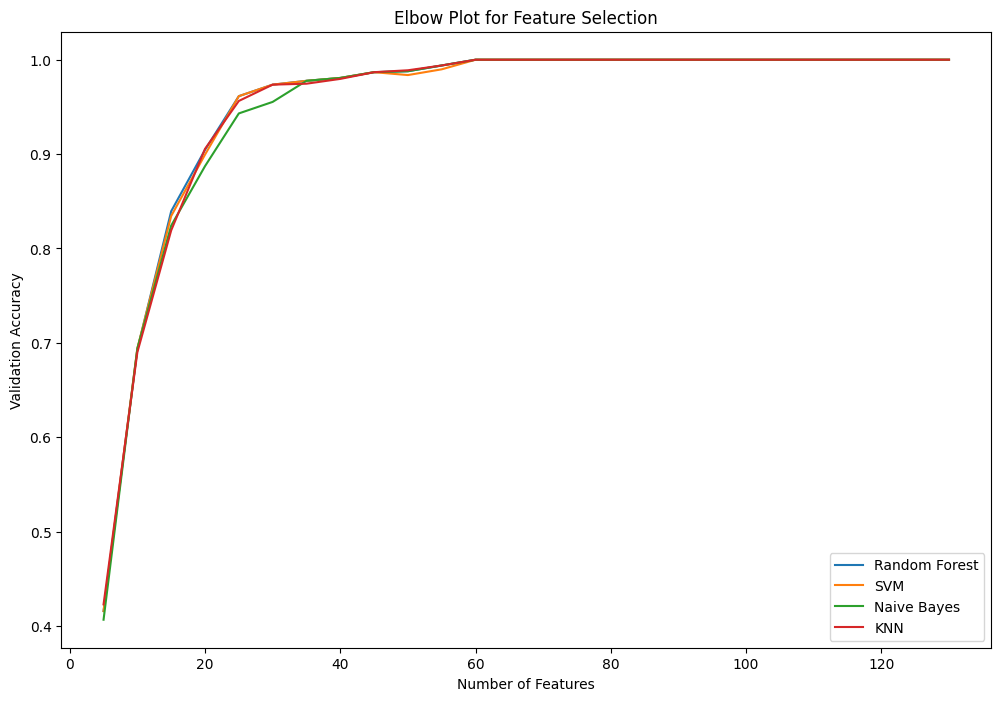

In [14]:
# رسم نمودار ارنج برای هر مدل
plt.figure(figsize=(12, 8))
for model_name, accuracies in model_accuracies.items():
    plt.plot(feature_counts, accuracies, label=model_name)

plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.title("Elbow Plot for Feature Selection")
plt.legend()
plt.show()

In [33]:
# تعداد ویژگی‌های مورد نظر (45)
n_features_to_select = 45  

# اعمال RFE روی مدل RandomForest
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=n_features_to_select)
rfe.fit(X_train_split, y_train_split)

# استخراج ویژگی‌های انتخاب‌شده
selected_features = X_train_split.columns[rfe.support_]
print(f"Selected Features ({n_features_to_select}):\n", selected_features)

Selected Features (45):
 Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'chills', 'joint_pain',
       'stomach_pain', 'vomiting', 'fatigue', 'weight_loss', 'lethargy',
       'cough', 'high_fever', 'breathlessness', 'sweating', 'headache',
       'dark_urine', 'nausea', 'loss_of_appetite', 'constipation',
       'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellowing_of_eyes',
       'malaise', 'chest_pain', 'fast_heart_rate', 'neck_pain', 'knee_pain',
       'movement_stiffness', 'loss_of_balance', 'unsteadiness',
       'continuous_feel_of_urine', 'internal_itching', 'depression',
       'irritability', 'muscle_pain', 'altered_sensorium',
       'abnormal_menstruation', 'family_history', 'stomach_bleeding',
       'fluid_overload.1', 'prominent_veins_on_calf', 'blackheads',
       'silver_like_dusting', 'yellow_crust_ooze'],
      dtype='object')


In [34]:
# انتخاب ویژگی‌ها با استفاده از RFE و Random Forest
best_n_features = 45  # تعداد ویژگی‌ها به صورت دلخواه
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=best_n_features)
X_train_rfe = rfe.fit_transform(X_train_split, y_train_split)
X_val_rfe = rfe.transform(X_val)
X_test_rfe = rfe.transform(X_test)

In [35]:
# تعریف تابع برای رسم کانفیوژن ماتریس
def plot_confusion_matrix(model, X_test, y_test, model_name):
    preds = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} on Test Data")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Accuracy on train data by Random Forest: 99.42%
Accuracy on validation data by Random Forest: 98.68%
Accuracy on test data by Random Forest: 100.00%

Macro Average for Random Forest:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Weighted Average for Random Forest:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


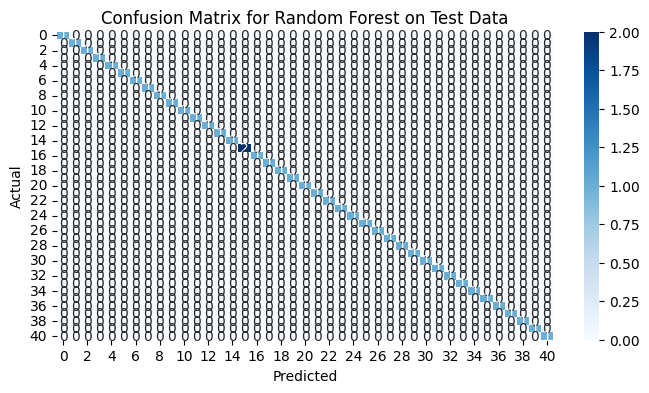

Accuracy on train data by SVM: 99.42%
Accuracy on validation data by SVM: 98.68%
Accuracy on test data by SVM: 100.00%

Macro Average for SVM:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Weighted Average for SVM:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


<Figure size 1200x800 with 0 Axes>

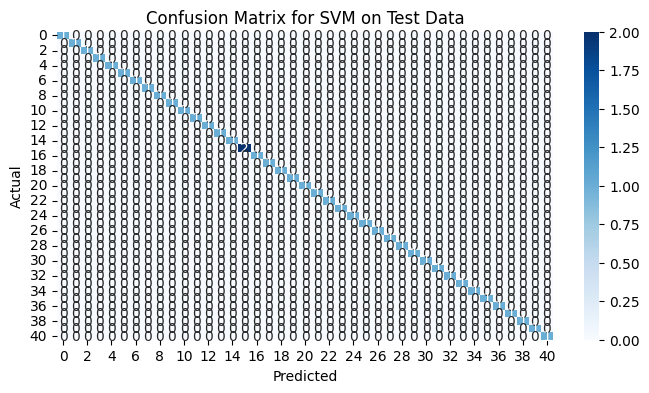

Accuracy on train data by Naive Bayes: 99.42%
Accuracy on validation data by Naive Bayes: 98.68%
Accuracy on test data by Naive Bayes: 100.00%

Macro Average for Naive Bayes:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Weighted Average for Naive Bayes:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


<Figure size 1200x800 with 0 Axes>

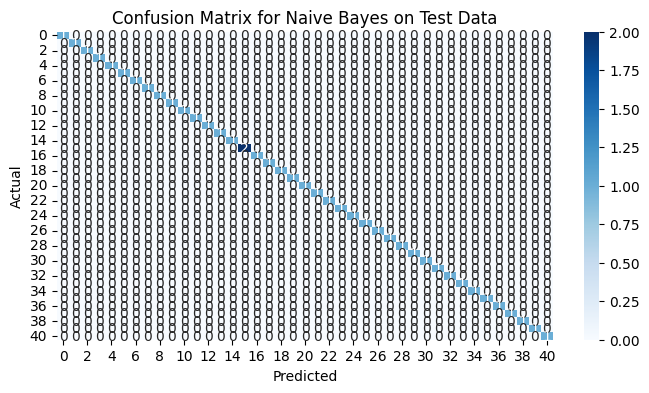

Accuracy on train data by KNN: 99.42%
Accuracy on validation data by KNN: 98.68%
Accuracy on test data by KNN: 100.00%

Macro Average for KNN:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Weighted Average for KNN:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


<Figure size 1200x800 with 0 Axes>

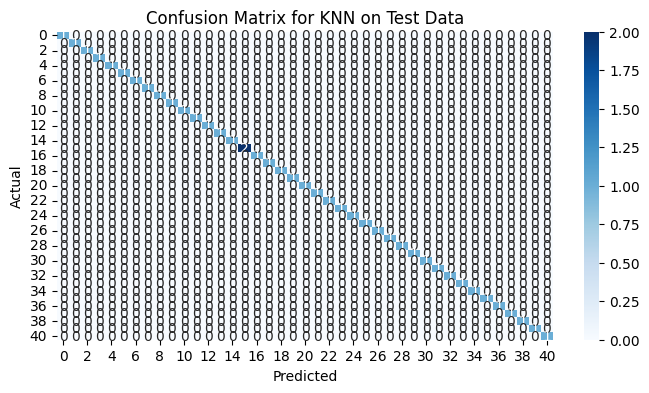

<Figure size 1200x800 with 0 Axes>

In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

for model_name, model in models.items():
    # آموزش مدل
    model.fit(X_train_rfe, y_train_split)
    
    # دقت روی داده‌های آموزش و اعتبارسنجی
    train_accuracy = accuracy_score(y_train_split, model.predict(X_train_rfe)) * 100
    val_accuracy = accuracy_score(y_val, model.predict(X_val_rfe)) * 100
    print(f"Accuracy on train data by {model_name}: {train_accuracy:.2f}%")
    print(f"Accuracy on validation data by {model_name}: {val_accuracy:.2f}%")
    
    # دقت روی داده‌های تست
    y_test_pred = model.predict(X_test_rfe)
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    print(f"Accuracy on test data by {model_name}: {test_accuracy:.2f}%")
    
    # گزارش classification_report
    report = classification_report(y_test, y_test_pred, output_dict=True)
    
    # نمایش Macro Average
    print(f"\nMacro Average for {model_name}:")
    print(f"Precision: {report['macro avg']['precision']:.2f}")
    print(f"Recall: {report['macro avg']['recall']:.2f}")
    print(f"F1-Score: {report['macro avg']['f1-score']:.2f}")
    
    # نمایش Weighted Average
    print(f"\nWeighted Average for {model_name}:")
    print(f"Precision: {report['weighted avg']['precision']:.2f}")
    print(f"Recall: {report['weighted avg']['recall']:.2f}")
    print(f"F1-Score: {report['weighted avg']['f1-score']:.2f}")
    
    # رسم کانفیوژن ماتریس
    plot_confusion_matrix(model, X_test_rfe, y_test, model_name)
    plt.figure(figsize=(12,8))

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
# ایجاد مدل ترکیبی با استفاده از مدل‌های از پیش تعریف شده
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('svm', models["SVM"]),
        ('nb', models["Naive Bayes"]),
        ('knn', models["KNN"])
    ],
    voting='soft'
)

In [39]:
# آموزش مدل ترکیبی
ensemble_model.fit(X_train_rfe, y_train_split)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True)),
                             ('nb', GaussianNB()),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [40]:
train_accuracy = accuracy_score(y_train_split, ensemble_model.predict(X_train_rfe)) * 100
val_accuracy = accuracy_score(y_val, ensemble_model.predict(X_val_rfe)) * 100
print(f"Accuracy on train data by Ensemble Model: {train_accuracy:.2f}%")
print(f"Accuracy on validation data by Ensemble Model: {val_accuracy:.2f}%")


Accuracy on train data by Ensemble Model: 99.42%
Accuracy on validation data by Ensemble Model: 98.68%


In [41]:
# دقت روی داده‌های تست
y_test_pred = ensemble_model.predict(X_test_rfe)
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Accuracy on test data by Ensemble Model: {test_accuracy:.2f}%")

Accuracy on test data by Ensemble Model: 100.00%


In [42]:
# گزارش classification_report
report = classification_report(y_test, y_test_pred, output_dict=True)

In [43]:
# نمایش Macro Average
print(f"\nMacro Average for Ensemble Model:")
print(f"Precision: {report['macro avg']['precision']:.2f}")
print(f"Recall: {report['macro avg']['recall']:.2f}")
print(f"F1-Score: {report['macro avg']['f1-score']:.2f}")


Macro Average for Ensemble Model:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


In [44]:
# نمایش Weighted Average
print(f"\nWeighted Average for Ensemble Model:")
print(f"Precision: {report['weighted avg']['precision']:.2f}")
print(f"Recall: {report['weighted avg']['recall']:.2f}")
print(f"F1-Score: {report['weighted avg']['f1-score']:.2f}")


Weighted Average for Ensemble Model:
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


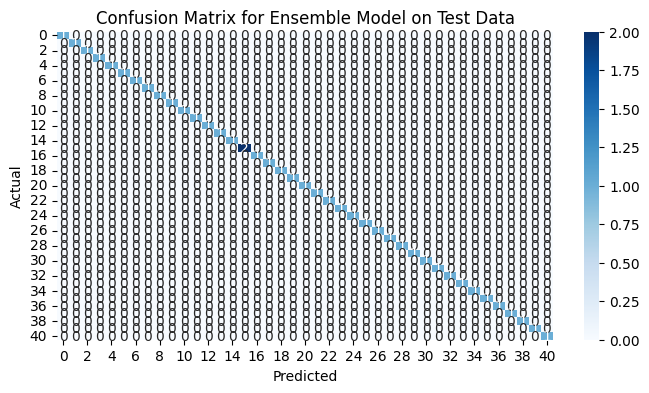

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [45]:
# رسم کانفیوژن ماتریس
plot_confusion_matrix(ensemble_model, X_test_rfe, y_test, "Ensemble Model")
plt.figure(figsize=(12,8))

In [46]:
if hasattr(ensemble_model, 'weights_'):
    print("Weights of models in the ensemble:")
    for estimator, weight in zip(ensemble_model.estimators_, ensemble_model.weights_):
        print(f"{estimator[0]}: {weight}")
else:
    print("No weights available. Equal weighting is used.")

No weights available. Equal weighting is used.


In [47]:
import numpy as np

# پیش‌بینی برای هر مدل و مدل ترکیبی
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test_rfe)
predictions['Ensemble'] = ensemble_model.predict(X_test_rfe)

# مقایسه پیش‌بینی‌ها
for name in predictions:
    accuracy = np.mean(predictions[name] == y_test) * 100
    print(f"Accuracy of {name}: {accuracy:.2f}%")

# بررسی تعداد موارد اختلاف
for name in models:
    diff = np.sum(predictions[name] != predictions['Ensemble'])
    print(f"Number of different predictions between {name} and Ensemble: {diff}")

Accuracy of Random Forest: 100.00%
Accuracy of SVM: 100.00%
Accuracy of Naive Bayes: 100.00%
Accuracy of KNN: 100.00%
Accuracy of Ensemble: 100.00%
Number of different predictions between Random Forest and Ensemble: 0
Number of different predictions between SVM and Ensemble: 0
Number of different predictions between Naive Bayes and Ensemble: 0
Number of different predictions between KNN and Ensemble: 0
